In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
def load_dataset():
    # Function to load the dataset from python pickle format
    with open("datasets/is_cat_dataset", "rb") as f:
        dic = pickle.load(f)
    # Separate the dictionary into train and test 
    train_x = dic['train_X']
    train_y = dic['train_y']
    test_x = dic['test_X']
    test_y = dic['test_y']
    classes = dic['class']
    # return the split values
    return train_x, train_y, test_x, test_y, classes

# 1 - Loading Dataset

In [3]:
# Load the is_cat dataset with the helper function
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y_label = 0, it's a 'non-cat' image.


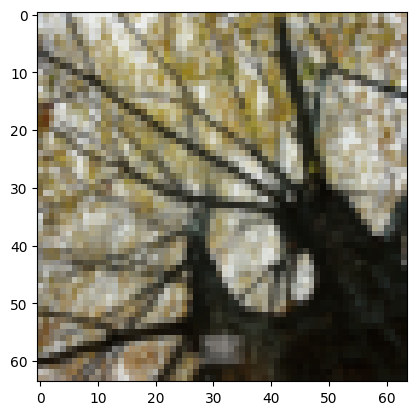

In [4]:
# Display a random image from the train set
def show_image(x, y, classes):
    # Function for display a image
    index = np.random.randint(len(x))
    y_value = y[0, index]
    classname = classes[np.squeeze(y[:, index])]
    
    plt.imshow(x[index])
    print(f"y_label = {y_value}, it's a '{classname}' image.")
    
show_image(train_set_x_orig, train_set_y, classes)

# 2 - Checking and transpose 

In [5]:
# Checking the dataset 
m_train = train_set_x_orig.shape[0]
m_test =  test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

assert m_train == 209, "M train must be 209, please check the dataset"
assert m_test == 50, "M test must be 50, please check the dataset"
assert num_px == 64, "Image is 64px by 64 px"

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [6]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
sanity_check = train_set_x_flatten[0:5, 0]

assert train_set_x_flatten.shape == (12288, 209), "train_set_x_flatten shape mismatch"
assert test_set_x_flatten.shape == (12288, 50), "test_set_x_flatten shape mismatch"
assert np.array_equal(sanity_check, [17, 31, 56, 22, 33]), "failed Sanity check"

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [7]:
# Normalize the pixel value from range of 0 - 255 to 0 - 1
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

# 3 - Building the Model

### Sigmoid Function

Activation function, where given x to output of value between 0 and 1.


Function: $\Large\frac{1}{1 + e^{-z}}$


- If z is large, sigmoid = 1 or close to 1
- If z is small or large negative, sigmoid = 0 or close to 0

In [8]:
def sigmoid(z):
    # Sigmoid Function: 1 / 1 + exp(-z)
    return 1 / (1 + np.exp(-z))

In [9]:
# Checking sigmoid function
# Please don't change this cell
x = sigmoid(np.array([0, 2]))
assert np.array_equal(np.round(x, 8), [0.5, 0.88079708]), "There is something wrong with your sigmoid function."
print(f"Sigmoid Function PASSED! With output value of {x} when input is [0, 2]")

Sigmoid Function PASSED! With output value of [0.5        0.88079708] when input is [0, 2]


### Function for initializing W and b with zeros

Where W with shape of (dimension of X, 1) and b is an integer.

In [10]:
# Initialize w and b with zeros
def initialize_with_zeros(dim):
    return np.zeros((dim, 1)), 0

In [11]:
# Checking initialize_with_zeros function
# Please don't change this cell
dim = 2
w, b = initialize_with_zeros(dim)
assert w.shape == (dim, 1), "Shape of w is wrong."
assert np.array_equal(w, [[0], [0]]), "Values of w is wrong."
assert b == 0, "Values of b is wrong."
print("PASSED!")
print(f"W = {w} with shape of {w.shape}")
print(f"b = {b}")

PASSED!
W = [[0.]
 [0.]] with shape of (2, 1)
b = 0


### Propagation

Where:

**Forward Propagation**

- m is total length of X
- A is Sigmoid of dot product of $w^{T}x$ then + b


**Cost Function** :
  
$\Large -\frac{1}{m} \sum^{m}_{i=1} (y * \log{A} + (1 - Y) * \log(1 - A))$


**Backward Propagation**
- **Update derivative for z**
  - dz = A - Y
- **Update derivative of W and b**
  - dw = dot product of $Xdz^{T}$ divide by m
  - db = sum of dz divide by m

In [12]:
# Propagation Function
def propagate(w, b, X, Y):
    m = X.shape[1]
    # Forward propagation (from X to cost)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1 / m) * np.sum((Y * np.log(A) + (1 - Y) * np.log(1 - A)))
    
    # Backward propagation (to find gradients)
    dz = A - Y
    dw = np.dot(X, dz.T) / m
    db = np.sum(dz) / m
    
    grads = {"dw": dw, 
             "db": db}
    
    return grads, cost

In [13]:
# Check Propagation Function
# Please don't change this cell
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)

assert np.array_equal(np.round(grads["dw"], 8), [[.99845601], [2.39507239]]), "dw is wrong."
assert np.round(grads["db"], 8) == .00145558, "db is wrong"
assert np.round(cost, 8) == 5.80154532, "Cost Function is wrong"

print("PASSED!")
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

PASSED!
dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### Optimization

Where updating W and b with dw and db:
- W = W - (learning rate * dw)
- b = b - (learning rate * db)

In [14]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    for i in range(num_iterations):
        # Get cost and gradients
        grads, cost = propagate(w, b, X, Y)
        
        # Retrive derivatives from gradients
        dw = grads['dw']
        db = grads['db']
        
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)
        
        # Record costs
        # if i % 100 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [15]:
# Checking Optimization Function
# Please don't edit this cell
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

assert np.array_equal(np.round(params["w"], 8), [[.19033591], [.12259159]]), "Check optimization for W."
assert np.round(params["b"], 8) == 1.92535983, "Check optimization for b"

print("PASSED!")
print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))

PASSED!
w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


### Prediction Function

In [16]:
def predict(w, b, X):
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    # Return rounded A 
    return np.round(A, 0).astype(int)

In [17]:
# Checking Predict Function
# Please don't change this cell
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
prediction = predict(w, b, X)

assert np.array_equal(prediction, [[1, 1, 0]]), "Please check your predict function"

print(f"PASSED! with prediction values of {prediction}")

PASSED! with prediction values of [[1 1 0]]


### Putting It all Together

In [18]:
def model(X_train, 
          Y_train, 
          X_test, 
          Y_test, 
          num_iterations=2000, 
          learning_rate=0.5,
          print_cost=False):
    
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, 
                                        X_train, 
                                        Y_train, 
                                        num_iterations, 
                                        learning_rate, 
                                        print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # train/test Errors
    train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "train_acc": train_acc,
         "test_acc": test_acc}
    
    return d

In [19]:
# Train model and validate model
# Please don't change this cell
d = model(train_set_x, train_set_y, 
          test_set_x, test_set_y, 
          num_iterations = 2000, 
          learning_rate = 0.005, 
          print_cost = False)

assert d["train_acc"] >= 99, "Training Accuracy should be greater than 99%."
assert d["test_acc"] >= 69, "Test Accuracy should be greater than 69%."

print("PASSED!")
print("With 2000 iteration and learing rate of 0.005:")
print(f"This model has a Train Accuracy of {d['train_acc']:.2f}%.")
print(f"This model has a Test Accuracy of {d['test_acc']:.2f}%.")

PASSED!
With 2000 iteration and learing rate of 0.005:
This model has a Train Accuracy of 99.04%.
This model has a Test Accuracy of 70.00%.


### Display Prediction

Your model prediction is correct.
The image is a 'cat'.


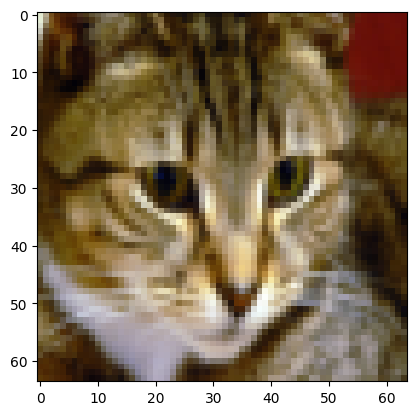

In [20]:
# Randomly display prediction vs true label from the test set data
index = np.random.randint(0, 50)
reshape_x_image = test_set_x[:, index].reshape((num_px, num_px, 3))
true_classname = classes[test_set_y[0, index]]
pred_classname = classes[int(d["Y_prediction_test"][0, index])]
is_pred_correct = true_classname == pred_classname
plt.imshow(reshape_x_image)
print(f"Your model prediction is {'correct' if is_pred_correct else 'not correct'}.")
print(f"The image is a '{true_classname}'.")

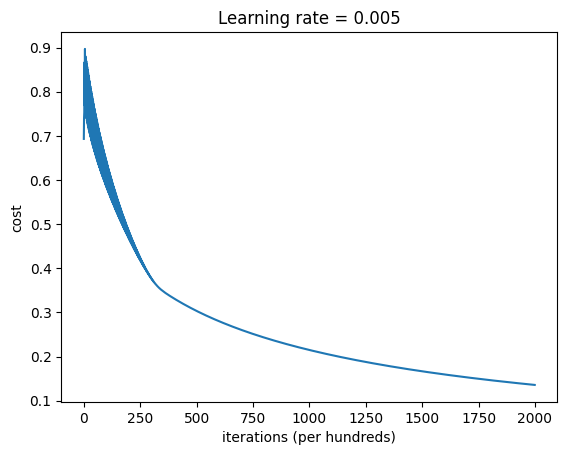

In [21]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()

# 4 - Rebuild Logistic Regression into a Class

In [22]:
class LogisticRegression:
    def __init__(self):
        self.costs = []
    
    def fit(self, X, y, 
            num_iteration:int=2000, 
            learning_rate:float=0.005, 
            print_cost:bool=False, 
            test_set:tuple=None):
        """
        Method to train the Logistic Regression Model.
        Parameter:
        X : array = input data
        y : array = labels
        num_iteration : int = number of training iteration
        learning_rate : float = value for learning rate
        print_cost : bool = for display cost every 100 iteration
        test_set: tuple = if is not None, will validate model after training is complete
        
        """
        if test_set is not None:
            # Making sure test_set is a tuple
            assert isinstance(test_set, tuple), "Make sure test_set is a tuple."
        # Getting M
        self.m = X.shape[1]
        # Assign learning rate
        self.lr = learning_rate
        # Initializing W and b
        self.w, self.b = self.__init_with_zeros(X.shape[0])
        # Loop for calculate cost and updating W and b (gradient decent)
        for i in range(num_iteration):
            # Forward Propogation
            A, c = self.__forward_propogate(X, y)
            # Append costs
            self.costs.append(c)
            # Backward Propogation
            dw, db = self.__backward_propogate(A, X, y)
            # Update derivative
            self.__update_derivative(dw, db)
            
            if print_cost:
                # Print cost every 100 iterations
                if (i+1) % 100 == 0:
                    print(f"After {i+1} iterations: cost is {c:.4f}.")
                    
        # Print Cost, train set accuracy, and test set accuracy at end of training
        acc = self.validate(X, y) * 100
        print(f"After {num_iteration} with learning rate of {self.lr}:")
        print(f"  Final cost is {self.costs[-1]:.4f}.")
        print(f"  Training data set accuracy of {acc:.2f}%.")
        if test_set is not None:
            test_acc = self.validate(test_set[0], test_set[1]) * 100
            print(f"  Test set accuracy is {test_acc:.2f}%.")
        
    
    def predict(self, X):
        # Check if input shape is same as weight
        assert X.shape[0] == self.w.shape[0], "Input data shape mismatch."
        # Return an array of 0s and 1s
        return np.round(self.__calculate_A(X), 0).astype(int)
    
    def validate(self, X, y):
        # Validate between input X and label y
        pred = self.predict(X)
        # Return accuracy value
        return np.mean(pred == y)
    
    def display_cost_graph(self, figsize=(12, 8)):
        # Display the cost graph
        costs = np.squeeze(self.costs)
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate = " + str(d["learning_rate"]))
        plt.figure(figsize=figsize)
        plt.show()
    
    def __update_derivative(self, dw, db):
        # Updating W and b with learning rate * derivative
        self.w -= self.lr * dw
        self.b -= self.lr * db
    
    def __backward_propogate(self, A, X, y):
        # Backward propogation
        # Calculate derivative of z : A - y
        dz = A - y 
        # Return dw = (X * transpose(dz)) / m, db = sum of dz / m
        return np.dot(X, dz.T) / self.m, np.sum(dz) / self.m
    
    def __forward_propogate(self, X, y):
        # Forward propogation
        # First calculate A then get cost
        A = self.__calculate_A(X)
        cost = self.__cost(A, y)
        # Returns A and cost
        return A, cost
    
    def __cost(self, A, y):
        # Calculate Cost with -1/m * sum of (y * Log(A) + (1 - y) * log(1 - A))
        return -(1 / self.m) * np.sum((y * np.log(A) + (1 - y) * np.log(1 - A)))
    
    def __calculate_A(self, X):
        # Calculate A : sigmoid(transpose(W) * X + b)
        return self.__sigmoid(np.dot(self.w.T, X) + self.b)
    
    def __init_with_zeros(self, dim):
        # Initialize W and b with zero
        return np.zeros((dim, 1)), 0
    
    def __sigmoid(self, z):
        # Sigmoid Activation Function : 1 / (1 + exp(-z))
        return 1 / (1 + np.exp(-z))

In [23]:
log_reg = LogisticRegression()

In [25]:
log_reg.fit(train_set_x, train_set_y, num_iteration=2000, print_cost=False, test_set=(test_set_x, test_set_y))

After 2000 with learning rate of 0.005:
  Final cost is 0.1357.
  Training data set accuracy of 99.04%.
  Test set accuracy is 70.00%.


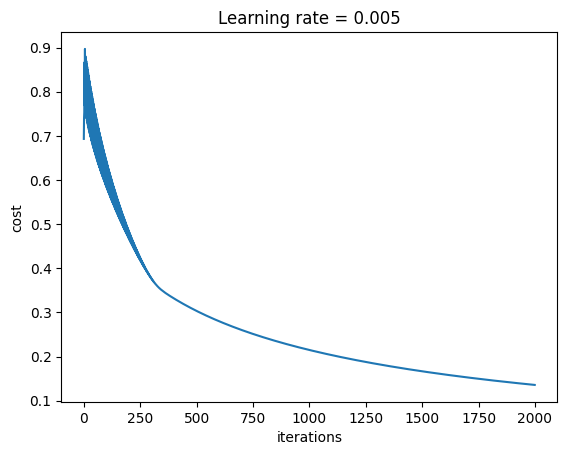

<Figure size 1200x800 with 0 Axes>

In [26]:
log_reg.display_cost_graph()